# Evaluate the cortical distribution of Sensory, Logic, and Motor Parallelism with the Margulies hierarchical gradients

In [2]:
import numpy as np
import nibabel as nib
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
plt.rcParams['font.sans-serif'] = "Arial"

In [3]:
# Load network
# Using final partition
networkdef = np.loadtxt('../../data/network_partition.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

#### Load in gradient, parallelism, standard decoding maps, and parcellation maps

In [14]:
datadir = '../../data/results/'
# figuredir = '../figures/manuscriptFigures/Fig7_BrainANN_PSOverlap/'
neuripsdir = '../manuscripts/neurips2022/figures/Fig7_BoxPlotANNHumanHierarchyPS/'

rules = ['Motor','Logic','Sensory']
# rules = ['Sensory','Logic','Motor']
ps = {}
decoding = {}

for domain in rules:
    ps[domain] = nib.load(datadir + domain + 'RulePSGroup.dscalar.nii').get_fdata().T
    decoding[domain] = nib.load(datadir + domain + 'RuleDecoding.dscalar.nii').get_fdata().T

# Load in gradient
hierarchical_gradient = nib.load(datadir + '../hcp.gradients.dscalar.nii').get_fdata().T

# Load in glasser atlas
glasser = np.squeeze(nib.load(datadir + '../Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii').get_fdata())


##### Parcellate all data into 360 cortical regions

In [5]:
n_parcels = 360

parcel_gradient = np.zeros((n_parcels,2))
#
parcel_ps = {}
parcel_decoding = {}
for domain in rules:
    parcel_ps[domain] = np.zeros((n_parcels,))
    parcel_decoding[domain] = np.zeros((n_parcels,))
    
for roi in range(n_parcels):
    roi_ind = np.where(glasser==roi+1)[0]
    parcel_gradient[roi,:] = np.mean(hierarchical_gradient[roi_ind,:2],axis=0)*-1
    
    for domain in rules:
        parcel_ps[domain][roi] = np.mean(ps[domain][roi_ind,0],axis=0)
        parcel_decoding[domain][roi] = np.mean(decoding[domain][roi_ind,0],axis=0)
    

#### Tidy data into dataframe

In [6]:
df = {}
df['Gradient1'] = []
df['Gradient2'] = []
df['Parcel'] = []
df['Parallelism'] = []
df['Decoding'] = []
df['Domain'] = []
# df['Depth'] = []

# Normalize all PS and decoding scores for each domain
for domain in rules:
    parcel_ps[domain] = (parcel_ps[domain] - np.min(parcel_ps[domain]))/np.max(parcel_ps[domain])
#     parcel_decoding[domain] = (parcel_decoding[domain] - np.min(parcel_decoding[domain]))/np.max(parcel_decoding[domain])
    parcel_decoding[domain] = (parcel_decoding[domain])/np.max(parcel_decoding[domain])
    
for roi in range(n_parcels):
    net = networkdef[roi]
#     if net in sensory_nets: depth = 1
#     if net in association_nets: depth = 2
#     if net in motor_nets: depth = 3
    for domain in rules:
        df['Parcel'].append(roi+1)
        df['Gradient1'].append(parcel_gradient[roi,0])
        df['Gradient2'].append(parcel_gradient[roi,1])
        df['Parallelism'].append(parcel_ps[domain][roi])
        df['Decoding'].append(parcel_decoding[domain][roi])
        df['Domain'].append(domain)
#         df['Depth'].append(depth)

        
df = pd.DataFrame(df)

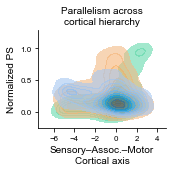

In [7]:
tmp = sns.color_palette('colorblind')
palette = [tmp[2],tmp[1],tmp[0]]
plt.figure(figsize=(2.5,2.5))
ax = sns.kdeplot(x="Gradient2",y="Parallelism",hue="Domain",data=df,shade=True,palette=palette,alpha=.6,legend=False)
plt.title('Parallelism across\ncortical hierarchy',fontsize=10)
# plt.xticks([-5,1],['Input','Output'],fontsize=10,rotation=10)
plt.xticks(np.arange(-6,6,2),fontsize=8)
plt.xlabel('Sensory–Assoc.–Motor\nCortical axis', fontsize=10)
plt.ylabel('Normalized PS',fontsize=10)
plt.yticks(fontsize=8)
# ax.legend_.set_bbox_to_anchor((0, 1.0))
# ax.legend_._set_loc(2)
# plt.setp(ax.get_legend().get_title(), fontsize='0')
# plt.setp(ax.get_legend().get_texts(), fontsize='6')
sns.despine()
plt.tight_layout()
# plt.savefig(figuredir + 'EmpiricalPSGradient.png',dpi=300)


# Discretize regions into sensory, association, and motor areas and compare with ANN PS scores by depth

PS for rule Sensory
	Layer 1 v 2 | t = 3.7919703855971485  | p = 0.0001787305456196154
	Layer 2 v 3 | t = 1.8567388278735453  | p = 0.06438733655786252
	Layer 1 v 3 | t = 4.642781069168452  | p = 9.410728135572134e-06
PS for rule Logic
	Layer 1 v 2 | t = -4.937013468060787  | p = 1.2812097782517647e-06
	Layer 2 v 3 | t = 4.376968365786142  | p = 1.6948470968166946e-05
	Layer 1 v 3 | t = 1.1890955227794953  | p = 0.23691701399286846
PS for rule Motor
	Layer 1 v 2 | t = -1.0612833717031307  | p = 0.2893639616841221
	Layer 2 v 3 | t = -19.085101558087445  | p = 9.146497730074624e-53
	Layer 1 v 3 | t = -13.720402179406474  | p = 9.833399769346083e-26


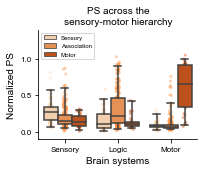

In [15]:
associationnets = ['con','dan','lan','fpn','dmn','pmulti','none1','none2']
sensorimotornets = ['vis1','vis2','smn','aud']
sensorynets = ['vis1','vis2','aud']
motornets = ['smn']

ruledomains = ['Sensory', 'Logic', 'Motor']

df_ps_brain = {}
df_ps_brain['Parallelism'] = []
df_ps_brain['System'] = []
df_ps_brain['Rule'] = []
df_ps_brain['Parcel'] = []

for net in sensorynets:
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        for domain in ruledomains:
            df_ps_brain['Parallelism'].append(parcel_ps[domain][roi])
            df_ps_brain['Rule'].append(domain)
            df_ps_brain['System'].append('Sensory')
            df_ps_brain['Parcel'].append(roi)

for net in associationnets:
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        for domain in ruledomains:
            df_ps_brain['Parallelism'].append(parcel_ps[domain][roi])
            df_ps_brain['Rule'].append(domain)
            df_ps_brain['System'].append('Association')
            df_ps_brain['Parcel'].append(roi)
        
for net in motornets:
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        for domain in ruledomains:
            df_ps_brain['Parallelism'].append(parcel_ps[domain][roi])
            df_ps_brain['Rule'].append(domain)
            df_ps_brain['System'].append('Motor')
            df_ps_brain['Parcel'].append(roi)

df_ps_brain = pd.DataFrame(df_ps_brain)


plt.figure(figsize=(3.,2.5))
ax = sns.boxplot(x="Rule",y="Parallelism",hue='System',sym='',whis=[2.5,97.5],data=df_ps_brain,palette='Oranges') #,order=hierarchy_ind,palette=networkpalette)
sns.stripplot(x="Rule",y="Parallelism",hue='System',alpha=0.4,s=3,data=df_ps_brain,dodge=True,palette='Oranges',zorder=0)
# tmp = df_system.groupby('System',sort=False).mean()
# y = tmp.Dimensionality.values
# sns.lineplot(x="System",y="Dimensionality",data=tmp,markers=["o"],color=sns.color_palette("Set2")[6],linewidth=2,zorder=4)
# sns.scatterplot(x="System",y="Dimensionality",data=tmp,markers=["o"],color=sns.color_palette("Set2")[6],zorder=4)
# plt.plot(np.arange(0,3),y,'o',color=sns.color_palette("Set2")[6],linewidth=1)
plt.xticks(fontsize=10);
plt.xlabel('Brain systems',fontsize=10);
# plt.ylabel('Rep. dim.',fontsize=10);
plt.ylabel('Normalized PS',fontsize=10)
# plt.ylabel(None)
plt.title('PS across the\nsensory-motor hierarchy', fontsize=10);
plt.xticks(fontsize=8,rotation=0)
plt.yticks(fontsize=8)
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3],fontsize=6)
plt.tight_layout()
plt.ylim([-0.1,1.4])
sns.despine()
# plt.savefig(neuripsdir + '/PS_Hierarchy_Brain.png',dpi=300)


for rule in df_ps_brain.Rule.unique():
    tmpdf = df_ps_brain.loc[df_ps_brain.Rule==rule]
    print('PS for rule', rule)
    #
    t, p = stats.ttest_ind(tmpdf.loc[tmpdf.System=='Sensory'].Parallelism.values,tmpdf.loc[tmpdf.System=='Association'].Parallelism.values)
    print('\tLayer 1 v 2 | t =', t, ' | p =', p)
    #
    t, p = stats.ttest_ind(tmpdf.loc[tmpdf.System=='Association'].Parallelism.values,tmpdf.loc[tmpdf.System=='Motor'].Parallelism.values)
    print('\tLayer 2 v 3 | t =', t, ' | p =', p)
    #
    t, p = stats.ttest_ind(tmpdf.loc[tmpdf.System=='Sensory'].Parallelism.values,tmpdf.loc[tmpdf.System=='Motor'].Parallelism.values)
    print('\tLayer 1 v 3 | t =', t, ' | p =', p)
    

# Load in ANN data (3-layer model) to compare with brain data

PS for rule Sensory
	Layer 1 v 2 | t = 11.020642834383155  | p = 1.5210616696332704e-13
	Layer 2 v 3 | t = 2.1967886323138237  | p = 0.03404453606966684
	Layer 1 v 3 | t = 10.387932670085927  | p = 8.613415919262574e-13
PS for rule Logic
	Layer 1 v 2 | t = -3.9685738808885653  | p = 0.00030080164330678654
	Layer 2 v 3 | t = 6.047507859804625  | p = 4.448771802927088e-07
	Layer 1 v 3 | t = -1.2071035074323704  | p = 0.23466276955714205
PS for rule Motor
	Layer 1 v 2 | t = -7.512382182075072  | p = 4.285832842971316e-09
	Layer 2 v 3 | t = -0.703536192837779  | p = 0.48590093678932356
	Layer 1 v 3 | t = -6.043261396145786  | p = 4.509609419122185e-07


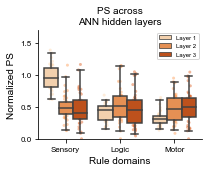

In [16]:

datadir = '../../data/model_results/experiment10/'
simstart = 0 
simend = 40
nlayers = 3

#
df_adam0_combined = pd.read_csv(datadir + 'expt10_adam_zeroshot_' + str(nlayers) + 'layers_pretraining_2rulepretraining_simData' + str(simstart) + '.csv')
df_adam0_combined.insert(len(df_adam0_combined.columns),"Simulation",list(np.repeat(simstart,len(df_adam0_combined))),True)
df_adam0_combined.insert(len(df_adam0_combined.columns),"Layers",list(np.repeat(nlayers,len(df_adam0_combined))),True)
df_adam0_combined.insert(len(df_adam0_combined.columns),"Training",list(np.repeat('Combined',len(df_adam0_combined))),True)

for i in range(simstart+1,simend):
    ####

    #
    tmp = pd.read_csv(datadir + 'expt10_adam_zeroshot_' + str(nlayers) + 'layers_pretraining_2rulepretraining_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Layers",list(np.repeat(nlayers,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Combined',len(tmp))),True)
    tmp['LogicAvg'] = tmp[['LogicPS1', 'LogicPS2']].mean(axis=1)
    tmp['SensoryAvg'] = tmp[['SensoryPS1', 'SensoryPS2']].mean(axis=1)
    tmp['MotorAvg'] = tmp[['MotorPS1', 'MotorPS2']].mean(axis=1)
    tmp['PSavg'] = tmp[['LogicAvg', 'SensoryAvg','MotorAvg']].mean(axis=1)
    df_adam0_combined = df_adam0_combined.append(tmp)
    
    
df_adam0_combined.Accuracy = df_adam0_combined.Accuracy.values*100.0
df_all = df_adam0_combined

df_ps_combined = {}
df_ps_combined['Layer'] = []
df_ps_combined['LayerCount'] = []
df_ps_combined['Parallelism'] = []
df_ps_combined['Rule'] = []
df_ps_combined['Simulation'] = []

for i in range(0,40):
    # Concept pretraining
    tmpdf = df_adam0_combined.loc[df_adam0_combined.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==0]
    for depth in range(1,nlayers+1):
        for rule in ['Sensory','Logic','Motor']:
            df_ps_combined['Simulation'].append(i)
            df_ps_combined['Layer'].append('Layer ' + str(depth))
            df_ps_combined['LayerCount'].append(depth)
            df_ps_combined['Rule'].append(rule)
            df_ps_combined['Parallelism'].append(tmpdf[rule + 'PS' + str(depth)].values[0])
df_ps_combined = pd.DataFrame(df_ps_combined)

# tmpdf = df_ps_combined.groupby(["Rule","Layer"]).mean().reset_index()

# df_normalized = df_ps_combined
#### Normalize
df_normalized = pd.DataFrame()
# Normalize all PS and decoding scores for each domain
for domain in ['Sensory','Logic','Motor']:
    tmpdf = df_ps_combined.loc[df_ps_combined.Rule==domain].copy()
    tmpps = (tmpdf.Parallelism.values - tmpdf.Parallelism.min())/np.max(tmpdf.Parallelism.max())
#     tmpps = (tmpdf.Parallelism.values)/tmpdf.Parallelism.max()
#     tmpps = tmpdf.Parallelism.values
    tmpdf['Parallelism'] = tmpps
    df_normalized = df_normalized.append(tmpdf)


##### Plot
plt.figure(figsize=(3.,2.5))
ax = sns.boxplot(x="Rule",y="Parallelism",hue='Layer',sym='',whis=[2.5,97.5],data=df_normalized,palette='Oranges') #,order=hierarchy_ind,palette=networkpalette)
sns.stripplot(x="Rule",y="Parallelism",hue='Layer',alpha=0.4,s=3,data=df_normalized,dodge=True,palette='Oranges',zorder=0)
# tmp = df_system.groupby('System',sort=False).mean()
# y = tmp.Dimensionality.values
# sns.lineplot(x="System",y="Dimensionality",data=tmp,markers=["o"],color=sns.color_palette("Set2")[6],linewidth=2,zorder=4)
# sns.scatterplot(x="System",y="Dimensionality",data=tmp,markers=["o"],color=sns.color_palette("Set2")[6],zorder=4)
# plt.plot(np.arange(0,3),y,'o',color=sns.color_palette("Set2")[6],linewidth=1)
plt.xticks(fontsize=10);
plt.xlabel('Rule domains',fontsize=10);
# plt.ylabel('Rep. dim.',fontsize=10);
plt.ylabel(None)
# plt.ylabel(None)
plt.title('PS across\nANN hidden layers', fontsize=10);
plt.xticks(fontsize=8,rotation=0)
plt.yticks(fontsize=8)
plt.ylabel('Normalized PS',fontsize=10)
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3],fontsize=6)
plt.tight_layout()
plt.ylim([0,1.7])
sns.despine()
plt.savefig(neuripsdir + 'PS_Hierarchy_ANN.png',dpi=300)

for rule in df_normalized.Rule.unique():
    tmpdf = df_normalized.loc[df_normalized.Rule==rule]
    print('PS for rule', rule)
    #
    t, p = stats.ttest_rel(tmpdf.loc[tmpdf.LayerCount==1].Parallelism.values,tmpdf.loc[tmpdf.LayerCount==2].Parallelism.values)
    print('\tLayer 1 v 2 | t =', t, ' | p =', p)
    #
    t, p = stats.ttest_rel(tmpdf.loc[tmpdf.LayerCount==2].Parallelism.values,tmpdf.loc[tmpdf.LayerCount==3].Parallelism.values)
    print('\tLayer 2 v 3 | t =', t, ' | p =', p)
    #
    t, p = stats.ttest_rel(tmpdf.loc[tmpdf.LayerCount==1].Parallelism.values,tmpdf.loc[tmpdf.LayerCount==3].Parallelism.values)
    print('\tLayer 1 v 3 | t =', t, ' | p =', p)
    
    


# Plot Sensory-Association-Motor System for visualization purposes

#### Surface mapping function

In [185]:
import os
projectdir = '../../'
glasserfile = projectdir + 'data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser = nib.load(glasserfile).get_fdata()
glasser = np.squeeze(glasser)

def mapBackToSurface(array,filename):
    """ 
    array can either be 360 array or ~59k array. If 360, will automatically map back to ~59k
    """
    #### Map back to surface
    if array.shape[0]==360:
        out_array = np.zeros((glasser.shape[0],3))

        roicount = 0 
        for roi in range(360):
            for col in range(array.shape[1]):
                vertex_ind = np.where(glasser==roi+1)[0]
                out_array[vertex_ind,col] = array[roicount,col]

            roicount += 1

    else:
        out_array = array

    #### 
    # Write file to csv and run wb_command
    np.savetxt(filename + '.csv', out_array,fmt='%s')
    wb_file = filename + '.dscalar.nii'
    wb_command = 'wb_command -cifti-convert -from-text ' + filename + '.csv ' + glasserfile + ' ' + wb_file + ' -reset-scalars'
    os.system(wb_command)
    os.remove(filename + '.csv')

In [195]:
parcels = np.zeros((360,1))

roi_total = 0
for net in sensorynets:
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        parcels[roi] = 1
    roi_total += len(rois)
print('Number of ROIs in sensory areas:', roi_total)

roi_total = 0
for net in associationnets:
    rois = np.where(networkdef==networkmappings[net])[0]

    for roi in rois:
        parcels[roi] = 2
    roi_total += len(rois)
print('Number of ROIs in association areas:', roi_total)        

roi_total = 0
for net in motornets:
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        parcels[roi] = 3
    roi_total += len(rois)
print('Number of ROIs in motor areas:', roi_total)
            
# mapBackToSurface(parcels,'../../data/Sensory_Assoc_Motor_Discretization')

Number of ROIs in sensory areas: 75
Number of ROIs in association areas: 246
Number of ROIs in motor areas: 39
